In [10]:
import re

def clean_text(text):
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove whitespace
    text = text.strip()
    return text

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import os

from tqdm.auto import tqdm
import time
from IPython.display import clear_output

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

#other stuff
save_dir = ""

#hyperparams
BATCH_SIZE = 32
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2

# Load data
df_train = pd.read_csv('data/kaggle-disaster-tweets/train.csv').drop(['id', 'location'], axis=1)
df_train.fillna('', inplace=True)

#combine 'keyword' into 'text' if 'keyword' is not NaN or an empty string
df_train['text'] = df_train.apply(lambda row: (row['keyword'] + " " if row['keyword'] else "") + row['text'], axis=1)

#already integrated into text, drop it
df_train.drop('keyword', axis=1, inplace=True)

#remvoes all the punctuatio 
df_train['text'] = df_train['text'].apply(clean_text)

vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
X = vectorizer.fit_transform(df_train['text']).toarray()
y = df_train['target'].values

import joblib

vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
X_train = vectorizer.fit_transform(df_train['text'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)

class TweetDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __getitem__(self, idx):
        return {
            'texts': torch.tensor(self.texts[idx], dtype=torch.float32).to(device),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long).to(device)
        }

    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(X_train, y_train)
val_dataset = TweetDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

Using device: mps


Validating -- Epoch 46/50: 100%|██████████| 48/48 [00:01<00:00, 38.18it/s]




Epoch 46
Train Loss: 0.1553
Val Loss: 0.5571
Val Accuracy: 0.7708
F1 Score:0.7710842549891788
Best Acc So Far:0.783322390019698
Current LR: [1.171875e-08]



Validating -- Epoch 47/50: 100%|██████████| 48/48 [00:01<00:00, 37.90it/s]




Epoch 47
Train Loss: 0.1493
Val Loss: 0.5562
Val Accuracy: 0.7715
F1 Score:0.771635786185363
Best Acc So Far:0.783322390019698
Current LR: [1.171875e-08]



Validating -- Epoch 48/50: 100%|██████████| 48/48 [00:01<00:00, 31.59it/s]




Epoch 48
Train Loss: 0.1500
Val Loss: 0.5668
Val Accuracy: 0.7689
F1 Score:0.7695026494971202
Best Acc So Far:0.783322390019698
Current LR: [1.171875e-08]



Validating -- Epoch 49/50: 100%|██████████| 48/48 [00:01<00:00, 36.95it/s]




Epoch 49
Train Loss: 0.1560
Val Loss: 0.5584
Val Accuracy: 0.7715
F1 Score:0.7719149542345864
Best Acc So Far:0.783322390019698
Current LR: [1.171875e-08]



Validating -- Epoch 50/50: 100%|██████████| 48/48 [00:01<00:00, 35.18it/s]



Epoch 50
Train Loss: 0.1622
Val Loss: 0.5729
Val Accuracy: 0.7663
F1 Score:0.767281047706479
Best Acc So Far:0.783322390019698
Current LR: [1.171875e-08]

Total Time Taken: 9.382460983594259 min
Best Validation Accuracy: 0.783322390019698


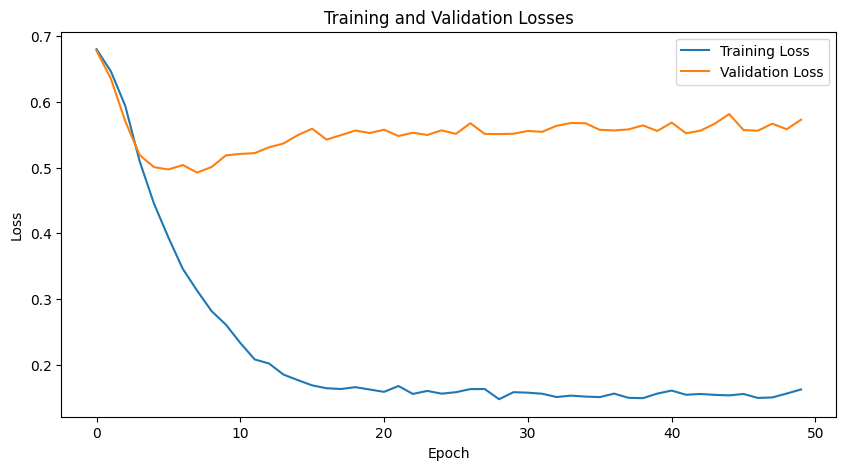

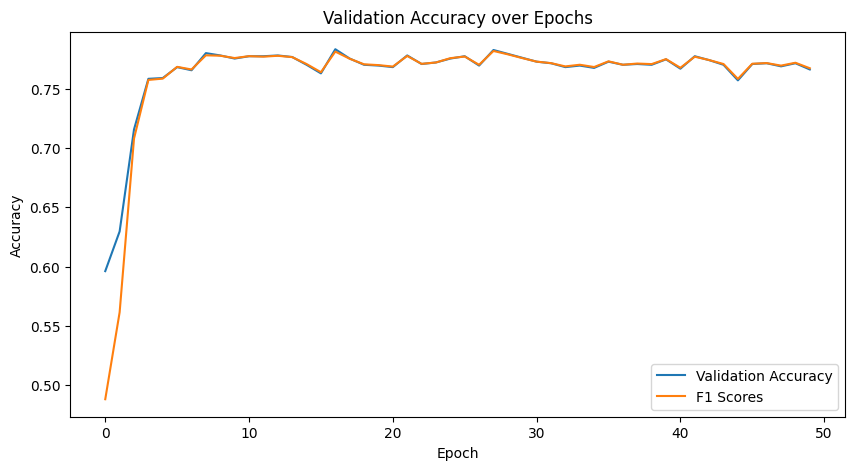

In [53]:
#this is our first, naive one
class TweetClassifier(nn.Module):
    def __init__(self, num_features, hidden_count=4096, dropout_p=0.4):
        super(TweetClassifier, self).__init__()
        
        self.sequence = nn.Sequential(
            nn.Linear(num_features, hidden_count),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(hidden_count, hidden_count),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(hidden_count, 2),
            nn.ReLU()
        )

    def forward(self, x):
        return self.sequence(x)

class ResidualTweetClassifier(nn.Module):
    def __init__(self, num_features, hidden_count=4096, dropout_p=0.35):
        super(ResidualTweetClassifier, self).__init__()
        
        self.fc1 = nn.Sequential(
            nn.Linear(num_features, hidden_count),
            nn.BatchNorm1d(hidden_count),
            nn.ReLU(),
            nn.Dropout(p=dropout_p)
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(hidden_count, hidden_count),
            nn.BatchNorm1d(hidden_count),
            nn.ReLU(),
            nn.Dropout(p=dropout_p)
        )

        self.fc3 = nn.Sequential(
            nn.Linear(hidden_count, hidden_count),
            nn.BatchNorm1d(hidden_count),
            nn.ReLU(),
            nn.Dropout(p=dropout_p)
        )

        self.fc4 = nn.Sequential(
            nn.Linear(hidden_count, hidden_count),
            nn.BatchNorm1d(hidden_count),
            nn.ReLU(),
            nn.Dropout(p=dropout_p)
        )

        self.fc_final = nn.Sequential(
            nn.Linear(hidden_count, 2),
            nn.ReLU()
        )
        
    def forward(self, x):
        x1 = self.fc1(x)

        x2 = x1 + self.fc2(x1)

        x3 = x2 + self.fc3(x2)

        x4 = x3 + self.fc4(x3)

        x_final = self.fc_final(x4)
        return x_final

# model = TweetClassifier(num_features=X_train.shape[1]).to(device)
model = ResidualTweetClassifier(num_features=X_train.shape[1]).to(device)
#model specific hyperparams
EPOCHS = 50
LEARNING_RATE = 3e-6

#model specific choices
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-3)
# optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-3)
# optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.5, weight_decay=1e-4)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

def save_checkpoint(save_dir, model, save_name = 'best_model.pth'):
    save_path = os.path.join(save_dir, save_name)
    torch.save(model.state_dict(), save_path)

def train_epoch(model, data_loader, criterion, optimizer):
    model.train()
    total_loss = 0
    for batch in tqdm(data_loader, desc=f"Training -- Epoch {epoch+1}/{EPOCHS}"):
        optimizer.zero_grad()
        inputs, labels = batch['texts'].to(device), batch['labels'].to(device)
        outputs = model(inputs).to(device)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)

def evaluate_model(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    correct_preds = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc=f"Validating -- Epoch {epoch+1}/{EPOCHS}"):
            inputs, labels = batch['texts'], batch['labels']
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            _, predicted = torch.max(outputs, dim=1)
            correct_preds += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    f1 = f1_score(all_labels, all_preds, average='weighted')

    return total_loss / len(data_loader), correct_preds / len(data_loader.dataset), f1

#store for plotting
train_losses = []
val_losses = []
val_accuracies = []
max_val_accuracy = -np.inf
f1_scores = []

start_time = time.time()
for epoch in range(EPOCHS):
    if epoch % 5 == 0: clear_output(wait=True)
    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_accuracy, f1 = evaluate_model(model, val_loader, criterion)
    
    lr_scheduler.step(val_loss)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    f1_scores.append(f1)
    
    if val_accuracy >= max_val_accuracy:
        max_val_accuracy = val_accuracy
        print("Saving Model")
        save_checkpoint(save_dir, model, save_name = 'best_model.pth')
    
    print(f'\n\nEpoch {epoch+1}\nTrain Loss: {train_loss:.4f}\nVal Loss: {val_loss:.4f}\nVal Accuracy: {val_accuracy:.4f}\nF1 Score:{f1}\nBest Acc So Far:{max_val_accuracy}\nCurrent LR: {lr_scheduler.get_last_lr()}\n')
    
print(f"Total Time Taken: {(time.time() - start_time)/60} min")
print(f"Best Validation Accuracy: {max_val_accuracy}")

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show

plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.plot(f1_scores, label='F1 Scores')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()